In [1]:
import torch
import torchvision.transforms as T
from torchvision.models.segmentation import deeplabv3_resnet101
from PIL import Image
import numpy as np


In [3]:

class GarmentSegmenter:
    def __init__(self):
        # Load pre-trained DeepLabV3 model
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = deeplabv3_resnet101(pretrained=True)
        self.model.eval()
        self.model.to(self.device)

        # Define image transformations
        self.transform = T.Compose([
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406], 
                       std=[0.229, 0.224, 0.225])
        ])

    def segment_garment(self, image_path):
        """
        Segments garment from an input image containing a mannequin.
        
        Args:
            image_path (str): Path to the input image
            
        Returns:
            numpy.ndarray: Binary mask where garment pixels are 1 and background is 0
        """
        # Load and preprocess the image
        image = Image.open(image_path).convert('RGB')
        input_tensor = self.transform(image)
        input_batch = input_tensor.unsqueeze(0).to(self.device)

        # Generate segmentation mask
        with torch.no_grad():
            output = self.model(input_batch)['out'][0]
        
        # Get the predictions
        output_predictions = output.argmax(0).cpu().numpy()

        # Create binary mask for garment class
        # Note: Class 15 in COCO dataset corresponds to 'person'
        # We assume the largest connected component in 'person' class is the garment
        binary_mask = (output_predictions == 15).astype(np.uint8)

        # Post-process the mask (remove small components and fill holes)
        from scipy import ndimage
        binary_mask = ndimage.binary_fill_holes(binary_mask)
        labeled_mask, num_features = ndimage.label(binary_mask)
        
        # Keep only the largest component
        if num_features > 0:
            sizes = ndimage.sum(binary_mask, labeled_mask, range(1, num_features + 1))
            largest_component = sizes.argmax() + 1
            binary_mask = (labeled_mask == largest_component).astype(np.uint8)

        return binary_mask

    def visualize_mask(self, image_path, mask):
        """
        Helper function to visualize the segmentation mask
        
        Args:
            image_path (str): Path to original image
            mask (numpy.ndarray): Binary segmentation mask
        """
        image = Image.open(image_path).convert('RGB')
        overlay = np.array(image) * (mask[..., None].astype(float))
        return Image.fromarray(overlay.astype(np.uint8))


In [5]:

# Usage example:
if __name__ == "__main__":
    segmenter = GarmentSegmenter()
    mask = segmenter.segment_garment("back_brown.jpg")
    
    # Optional: visualize the result
    overlay = segmenter.visualize_mask("back_brown.jpg", mask)
    overlay.save("segmentation_result.png")

C:\Users\Webhouse\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Webhouse\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to C:\Users\Webhouse/.cache\torch\hub\checkpoints\deeplabv3_resnet101_coco-586e9e4e.pth


100%|████████████████████████████████████████████████████████████████████████████| 233M/233M [00:43<00:00, 5.57MB/s]


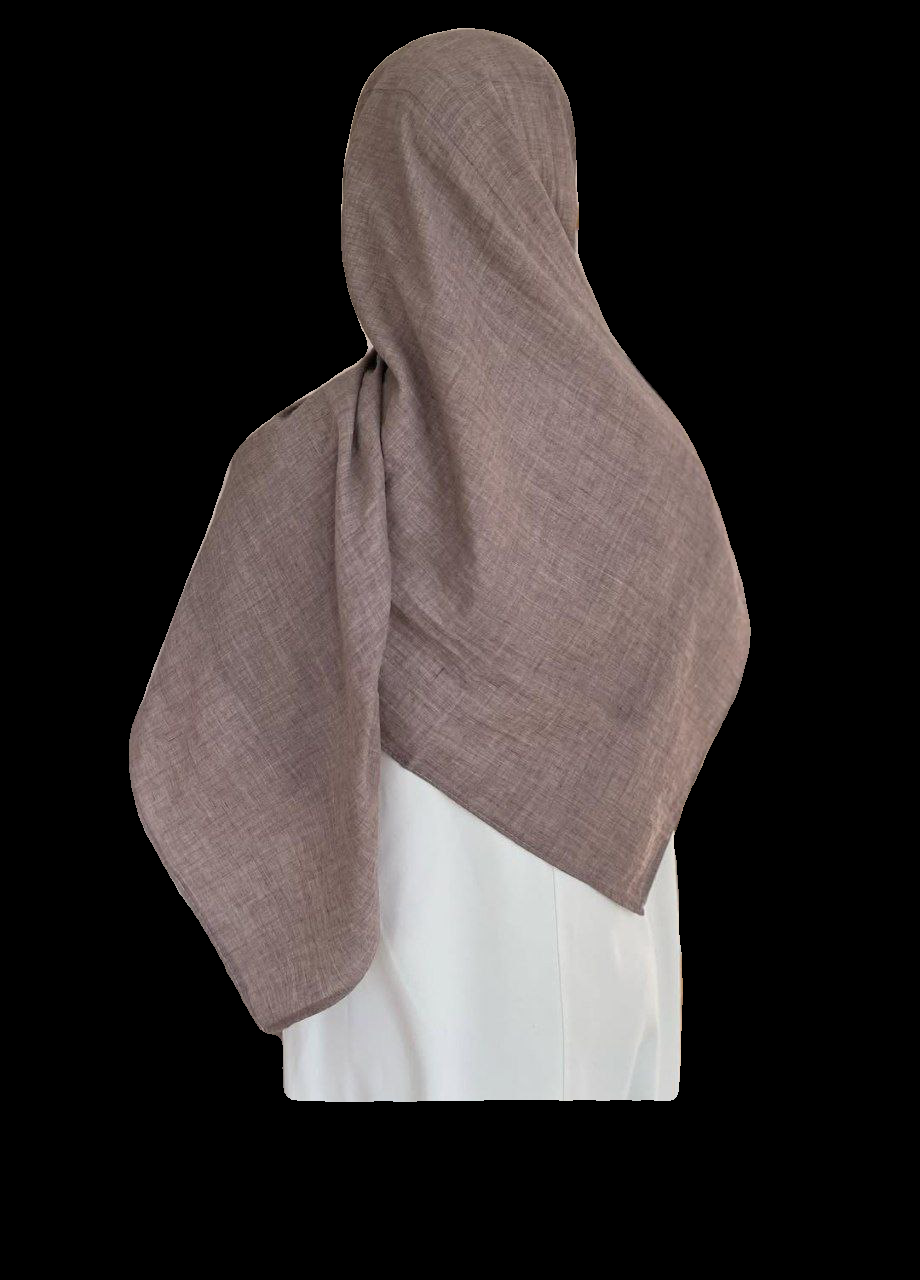

In [7]:
overlay